In [2]:
## this cell requires sentiment.csv file which is a huge file so won't run.
##Instead you can start from cell 2

import pandas as pd
#import pandasql as ps
from sklearn.metrics import confusion_matrix, classification_report

sentiment1 =  pd.read_csv('sentiment.csv')
#sentiment = ps.sqldf("""select 
#                        business_id,
#                        round(sentimental_rating,0) as sentimental_rating
#                        from sentiment1""", locals())
sentiment1 = sentiment1[['business_id', 'sentimental_rating']]
sentiment = sentiment1.round({'sentimental_rating': 0})

sentiment.describe()
sentiment.head()

business = pd.read_csv('business.csv')
business.rename(columns = {'stars':'business_stars'}, inplace = True)
business.head()
business.describe()
business.columns

####### REVIEW
review = pd.read_csv('review.csv', iterator=True, chunksize=500)
review = pd.concat(review, ignore_index =True)
review.describe()
review.columns
review.head()
business.head()

business_eateries = business[(business['categories'].str.contains(pat = 'Restaurants',na=False)) |
                                       (business['categories'].str.contains(pat = 'Lounges',na=False)) |
                                        (business['categories'].str.contains(pat = 'Nightlife',na=False)) |
                                        (business['categories'].str.contains(pat = 'Bars',na=False)) |
                                        (business['categories'].str.contains(pat = 'Food',na=False)) |
                                        (business['categories'].str.contains(pat = 'Coffee&Tea',na=False))|
                                        (business['categories'].str.contains(pat = 'Bakeries',na=False))|
                                        (business['categories'].str.contains(pat = 'Pubs',na=False))|
                                        (business['categories'].str.contains(pat = 'Pizza',na=False))]
business_eateries.describe()

business_eateries.columns
business_eateries.head()

cols = business_eateries.columns
cols = cols.map(lambda x: x.replace('.', '_'))
business_eateries.columns = cols
# write business_eateries csv
business_eateries.to_csv('Businesses_Eateries.csv')
business_eateries.head()

business_eateries_sentiment = pd.merge(business_eateries, sentiment, on = 'business_id')
business_eateries_sentiment.to_csv('Business_Eateries_Sentiment.csv')

business_review = pd.merge(business, review, on = 'business_id')
review_grouped = business_review.groupby(['city' , 'business_id'], as_index=False).mean()
data = review_grouped[['business_id','stars']]
review_eateries = data.apply(lambda x: x)
review_eateries.rename(columns={'stars': 'review_avg_stars'}, inplace=True)
review_eateries.head()

business_reviews_eateries = pd.merge(business_eateries, review_eateries, on = 'business_id')
business_reviews_eateries.head()
print(business_reviews_eateries.columns)

business_relevant_review_eateries = business_reviews_eateries[['business_id','latitude', 'longitude','review_count'
                  ,'business_stars','review_avg_stars','attributes_RestaurantsPriceRange2','attributes_BusinessAcceptsCreditCards','attributes_RestaurantsTakeOut','attributes_RestaurantsDelivery',
                        'attributes_WheelchairAccessible','attributes_GoodForMeal_breakfast','attributes_GoodForMeal_latenight','attributes_GoodForMeal_dessert','attributes_GoodForMeal_lunch',
                        'attributes_GoodForMeal_brunch','attributes_RestaurantsReservations','attributes_BusinessParking_validated','attributes_BusinessParking_valet','attributes_BusinessParking_lot','attributes_BusinessParking_garage',
                        'attributes_BusinessParking_street','attributes_BikeParking','state','city','name','attributes_GoodForKids','attributes_RestaurantsGoodForGroups','attributes_Ambience_trendy','attributes_Ambience_casual','attributes_Ambience_classy','attributes_Ambience_touristy','attributes_Ambience_intimate'
                        ,'attributes_Ambience_hipster']]


business_relevant_review_eateries.head()

business_relevant_review_eateries_sentiment = pd.merge(business_relevant_review_eateries, sentiment, on = 'business_id')
business_relevant_review_eateries_sentiment.to_csv('Model_Input.csv')
business_relevant_review_eateries_sentiment.head()

print("Data Cleaning Done!")

IOError: File sentiment.csv does not exist

In [4]:
from collections import defaultdict
import numpy
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.utils import column_or_1d
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import csv
import pandas as pd
#import pandasql as ps
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#reload(sys)
#sys.setdefaultencoding("utf-8")

attributes = ['attributes_RestaurantsPriceRange2',
              'attributes_BusinessAcceptsCreditCards',
              'attributes_RestaurantsTakeOut',
              'attributes_RestaurantsDelivery',
              'attributes_WheelchairAccessible',
              'attributes_GoodForMeal_breakfast',
              'attributes_GoodForMeal_latenight',
              'attributes_GoodForMeal_dessert',
              'attributes_GoodForMeal_lunch',
              'attributes_GoodForMeal_brunch',
              'attributes_RestaurantsReservations',
              'attributes_BusinessParking_validated',
              'attributes_BusinessParking_valet',
              'attributes_BusinessParking_lot',
              'attributes_BusinessParking_garage', 
              'attributes_BusinessParking_street',
              'attributes_BikeParking',
              'attributes_GoodForKids',
              'attributes_RestaurantsGoodForGroups',
              'attributes_Ambience_trendy',
              'attributes_Ambience_casual',
              'attributes_Ambience_classy',
              'attributes_Ambience_touristy',
              'attributes_Ambience_intimate',
              'attributes_Ambience_hipster',
              'latitude',
              'longitude',
              'business_stars', 
              'review_count', 
              'sentimental_rating',
              'review_avg_stars']

print('---- Reading Model_input.csv -------- ')

model_input_dict = defaultdict(dict)           

with open('Model_Input.csv') as csvfile:
    
    reader = csv.DictReader(csvfile)
    
    for row in reader:
        for attribute in attributes[:25]:
            if row[attribute] == 'TRUE':
                row[attribute] = 1
            elif row[attribute] == 'FALSE':
                row[attribute] = 0
            else:
                row[attribute] = 0
        
        model_input_dict[row['city']].update({ 
                                            row['business_id'] : 
                                            [ 
                                                int(row[attributes[0]]),
                                                int(row[attributes[1]]), 
                                                int(row[attributes[2]]), 
                                                int(row[attributes[3]]), 
                                                int(row[attributes[4]]), 
                                                int(row[attributes[5]]), 
                                                int(row[attributes[6]]), 
                                                int(row[attributes[7]]), 
                                                int(row[attributes[8]]), 
                                                int(row[attributes[9]]), 
                                                int(row[attributes[10]]), 
                                                int(row[attributes[11]]),
                                                int(row[attributes[12]]),
                                                int(row[attributes[13]]),
                                                int(row[attributes[14]]),
                                                int(row[attributes[15]]),
                                                int(row[attributes[16]]),
                                                int(row[attributes[17]]),
                                                int(row[attributes[18]]),
                                                int(row[attributes[19]]),
                                                int(row[attributes[20]]),
                                                int(row[attributes[21]]),
                                                int(row[attributes[22]]),
                                                int(row[attributes[23]]),
                                                int(row[attributes[24]]),
                                                float(row[attributes[25]]),
                                                float(row[attributes[26]]),
                                                float(row[attributes[27]]),
                                                int(row[attributes[28]]),
                                                float(row[attributes[29]]),
                                                int(numpy.round(float(row[attributes[30]]))),
                                            ]
                                            })


print('------Model Making Started-------')

results = defaultdict(list)
cities_models = defaultdict()

C:\Users\Harshit Vijayvargia\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---- Reading Model_input.csv -------- 
------Model Making Started-------


In [1]:
######################### Run this cell for RandomForest###############################################
for city, business_dict in model_input_dict.items():
    final_features = []
    final_labels = []
    #print(city)
    #print(business_dict)
    for business, features_list in business_dict.items():
        #print(business)
        #print(features_list)
        final_features.append(features_list[:-1]) #everything except the last item 
        final_labels.append(features_list[-1]) #last label
   
         
    #print(final_features)
    #print(final_labels)
    
    if len(final_features) < 4:
        continue
    
            
    features_train, features_test, labels_train, labels_test = train_test_split(numpy.array(final_features), numpy.array(final_labels), 
         
                                                                                     test_size=0.2, random_state = 42)
    #print(features_train)
    #print(features_test)
    #print(labels_train)
    #print(labels_test)
                                                                                
    #labels_train = column_or_1d(labels_train, warn=False)
    #labels_test = column_or_1d(labels_test, warn=False)          
    #print(labels_train)
    #print(labels_test)
    features_train_transformed = preprocessing.StandardScaler().fit_transform(features_train)
    features_test_transformed = preprocessing.StandardScaler().fit_transform(features_test)
    
    #clf = SVC(C=1).fit(features_train_transformed, labels_train)
    #train_accuracy = clf.score(features_train_transformed, labels_train)
    #test_accuracy = clf.score(features_test_transformed, labels_test)
    #print(train_accuracy)
    #print(test_accuracy)
    
    clf = RandomForestClassifier(n_estimators=10, max_depth=None,
            min_samples_split=2, random_state=0)
    clf = clf.fit(features_train_transformed, labels_train)
    train_accuracy = clf.score(features_train_transformed, labels_train)
    test_accuracy = clf.score(features_test_transformed, labels_test)

    if train_accuracy >=0.65 and test_accuracy>=0.60:
        cities_models[city] = clf
        results[city].append(features_train.shape)
        results[city].append(features_test.shape)
        results[city].append(train_accuracy)
        results[city].append(test_accuracy)
        
print('------Write accuracy in file-------')
final_results = []
for u, r in results.items():
    train_rows = r[0][0]
    test_rows = r[1][0]
    final_results.append([u, train_rows, test_rows, r[2], r[3]])
    
resultFile = open('Cities_Model_Fit_Accuracies_RandomForest.csv','w')
wr = csv.writer(resultFile, delimiter=',', lineterminator='\n' )
wr.writerow(['city', 'features_train_rows' , 'features_test_rows', 'train_accuracy', 'test_accuracy'])
wr.writerows(final_results)
resultFile.close()

# visualize train and test accuracies
sentiment = pd.read_csv('Cities_Model_Fit_Accuracies_RandomForest.csv')
sentiment = sentiment.tail(5)
sentiment['train_accuracy'] = sentiment['train_accuracy'].astype(float)
sentiment['test_accuracy'] = sentiment['test_accuracy'].astype(float)

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
x = sentiment.city
xn = range(len(x))
plt.xticks(xn, sentiment['city'])
ax1.plot(xn, sentiment['train_accuracy'], 'g-')
ax2.plot(xn, sentiment['test_accuracy'], 'r-')
ax1.set_xlabel('City')
ax1.set_ylabel('Train Accuracy', color='g')
ax2.set_ylabel('Test Accuracy', color='r')

NameError: name 'model_input_dict' is not defined

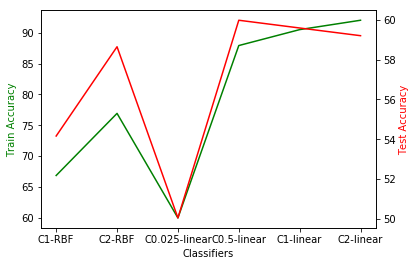

In [5]:
########################Visualize train and test accuracies with various SVM kernels###################
import matplotlib.pyplot as plt
%matplotlib inline
classifiers = [ SVC(kernel="rbf", C=1),
   SVC(kernel="rbf", C=2),
   SVC(kernel="linear", C=0.025),
   SVC(kernel="linear", C=0.5),
   SVC(kernel="linear", C=1),
   SVC(kernel="linear", C=2) ]

names = ["C1-RBF", "C2-RBF", "C0.025-linear", "C0.5-linear",
        "C1-linear", "C2-linear"]

train_list = []
test_list = []
for name, clf in zip(names, classifiers):
    tot_train = 0
    tot_test = 0
    count = 0
    for city, business_dict in model_input_dict.items():
        final_features = []
        final_labels = []
        #print(city)
        #print(business_dict)
        for business, features_list in business_dict.items():
            #print(business)
            #print(features_list)
            final_features.append(features_list[:-1]) #everything except the last item 
            final_labels.append(features_list[-1]) #last label
   
    
        #print(city)
        if len(final_features) < 8:
            continue
        count = count + 1
        #print(final_features)
        #print(final_labels)
        features_train, features_test, labels_train, labels_test = train_test_split(numpy.array(final_features), numpy.array(final_labels), 
                                                       test_size=0.2, random_state = 42)
        #print(features_train)
        #print(features_test)
        #print(labels_train)
        #print(labels_test)
                                                                                
        #labels_train = column_or_1d(labels_train, warn=False)
        #labels_test = column_or_1d(labels_test, warn=False)          
        #print(labels_train)
        #print(labels_test)
        features_train_transformed = preprocessing.StandardScaler().fit_transform(features_train)
        features_test_transformed = preprocessing.StandardScaler().fit_transform(features_test)
    
        clf = clf.fit(features_train_transformed, labels_train)
        train_accuracy = clf.score(features_train_transformed, labels_train)
        test_accuracy = clf.score(features_test_transformed, labels_test)
        #print(train_accuracy)
        #print(test_accuracy)
        
        tot_train = tot_train + train_accuracy*100
        tot_test = tot_test + test_accuracy*100
        #print(tot_train)
        #print(tot_test)
        #print(count)
    
    #print(tot_train)
    #print(tot_test)
    #print(count)
    if tot_train != 0 and tot_test != 0: 
        train_list.append((tot_train/count))
        test_list.append((tot_test/count))


#print(train_list)
#print(test_list)
list1 = names
list2 = train_list
list3 = test_list

#visualize train and test accuracies for different svm kernels
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
x = list1
xn = range(len(x))
plt.xticks(xn, list1)
ax1.plot(xn, list2, 'g-')
ax2.plot(xn, list3, 'r-')

ax1.set_xlabel('Classifiers')
ax1.set_ylabel('Train Accuracy', color='g')
ax2.set_ylabel('Test Accuracy', color='r')
#pylab.title('Visualize train and test accuracies with various SVM kernels')

In [7]:
######################################Run this cell for SVM############################################
for city, business_dict in model_input_dict.items():
    if len(business_dict)<20 :
        continue
    final_features = []
    final_labels = []
    #print(city)
    #print(business_dict)
    for business, features_list in business_dict.items():
        #print(business)
        #print(features_list)
        final_features.append(features_list[:-1]) #everything except the last item 
        final_labels.append(features_list[-1]) #last label
        

        
   
    
    #print(final_features)
    #print(final_labels)
    features_train, features_test, labels_train, labels_test = train_test_split(numpy.array(final_features), numpy.array(final_labels), 
                                                       test_size=0.2, random_state = 42)
    #print(features_train)
    #print(features_test)
    #print(labels_train)
    #print(labels_test)
                                                                                
    #labels_train = column_or_1d(labels_train, warn=False)
    #labels_test = column_or_1d(labels_test, warn=False)          
    #print(labels_train)
    #print(labels_test)
    features_train_transformed = preprocessing.StandardScaler().fit_transform(features_train)
    features_test_transformed = preprocessing.StandardScaler().fit_transform(features_test)
    
    clf = SVC(C=1).fit(features_train_transformed, labels_train)
    train_accuracy = clf.score(features_train_transformed, labels_train)
    test_accuracy = clf.score(features_test_transformed, labels_test)
    #print(train_accuracy)
    #print(test_accuracy)
    

    if train_accuracy >=0.65 and test_accuracy>=0.60:
        cities_models[city] = clf
        results[city].append(features_train.shape)
        results[city].append(features_test.shape)
        results[city].append(train_accuracy)
        results[city].append(test_accuracy)
        
print('------Write accuracy in file-------')
final_results = []
for u, r in results.items():
    train_rows = r[0][0]
    test_rows = r[1][0]
    final_results.append([u, train_rows, test_rows, r[2], r[3]])
    
resultFile = open('Cities_Model_Fit_Accuracies_SVM.csv','w')
wr = csv.writer(resultFile, delimiter=',', lineterminator='\n' )
wr.writerow(['city', 'features_train_rows' , 'features_test_rows', 'train_accuracy', 'test_accuracy'])
wr.writerows(final_results)
resultFile.close()

# visualize train and test accuracies
sentiment = pd.read_csv('Cities_Model_Fit_Accuracies_SVM.csv')
sentiment = sentiment.head(5)
sentiment['train_accuracy'] = sentiment['train_accuracy'].astype(float)
sentiment['test_accuracy'] = sentiment['test_accuracy'].astype(float)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
x = sentiment.city
xn = range(len(x))
plt.xticks(xn, sentiment['city'])
ax1.plot(xn, sentiment['train_accuracy'], 'g-')
ax2.plot(xn, sentiment['test_accuracy'], 'r-')
ax1.set_xlabel('City')
ax1.set_ylabel('Train Accuracy', color='g')
ax2.set_ylabel('Test Accuracy', color='r')

------Write accuracy in file-------


IOError: [Errno 13] Permission denied: 'Cities_Model_Fit_Accuracies_SVM.csv'

In [6]:
print("-----Generate list of Old Businesses for Cities -------")
all_cities_old_businesses = defaultdict(set)
for city, business_list in model_input_dict.items():
    if city in results.keys():
        for b in business_list.keys():
            all_cities_old_businesses[city].add(b)
            print(all_cities_old_businesses[city])

-----Generate list of Old Businesses for Cities -------
set(['gsgiyjbBs6hWfxQ4rFeEYA'])
set(['gsgiyjbBs6hWfxQ4rFeEYA', 'T96EG2iK3ZSv9ACiSFw4cw'])
set(['gsgiyjbBs6hWfxQ4rFeEYA', 'T96EG2iK3ZSv9ACiSFw4cw', 'CZMubW8II3eoXjTao-1aqg'])
set(['gsgiyjbBs6hWfxQ4rFeEYA', 'T96EG2iK3ZSv9ACiSFw4cw', 'CZMubW8II3eoXjTao-1aqg', 'GmvfPkjxhonLSaPgfNGhPw'])
set(['gsgiyjbBs6hWfxQ4rFeEYA', 'T96EG2iK3ZSv9ACiSFw4cw', 'CZMubW8II3eoXjTao-1aqg', 'GmvfPkjxhonLSaPgfNGhPw', 'EXt8OOwNE2CjoShPgLNdlg'])
set(['gsgiyjbBs6hWfxQ4rFeEYA', 'T96EG2iK3ZSv9ACiSFw4cw', 'CZMubW8II3eoXjTao-1aqg', 'EXt8OOwNE2CjoShPgLNdlg', 'GmvfPkjxhonLSaPgfNGhPw', 'ypSDELi0xMgoChahZkB3NA'])
set(['gsgiyjbBs6hWfxQ4rFeEYA', 'T96EG2iK3ZSv9ACiSFw4cw', 'CZMubW8II3eoXjTao-1aqg', 'EXt8OOwNE2CjoShPgLNdlg', '6VFWCI_JmkATlXCP8uZ26A', 'GmvfPkjxhonLSaPgfNGhPw', 'ypSDELi0xMgoChahZkB3NA'])
set(['gsgiyjbBs6hWfxQ4rFeEYA', 'T96EG2iK3ZSv9ACiSFw4cw', 'CZMubW8II3eoXjTao-1aqg', 'EXt8OOwNE2CjoShPgLNdlg', '6VFWCI_JmkATlXCP8uZ26A', 'GmvfPkjxhonLSaPgfNGhPw', 'ypSDELi0xMgo

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [7]:
###########################Build New Businesses for cities and do Prediction###########################
print("-----Generate list of Old Businesses for Cities -------")
all_cities_old_businesses = defaultdict(set)
for city, business_list in model_input_dict.items():
    if city in results.keys():
        for b in business_list.keys():
            all_cities_old_businesses[city].add(b)
            
print("----- Generate set of all businesses -------")
all_business = []
all_business_features = defaultdict(list)
with open('Business_Eateries_Sentiment.csv') as businessfile:
    b_reader = csv.DictReader(businessfile)
    for row in b_reader:
        business_id = row['business_id']
        all_business.append(business_id)  
        for attribute in attributes[:25]:
            if row[attribute] == 'TRUE':
                row[attribute] = 1
            elif row[attribute] == 'FALSE':
                row[attribute] = 0
            else:
                row[attribute] = 0
        all_business_features[row['business_id']] = [int(row[attributes[0]]),
                                                int(row[attributes[1]]), 
                                                int(row[attributes[2]]), 
                                                int(row[attributes[3]]), 
                                                int(row[attributes[4]]), 
                                                int(row[attributes[5]]), 
                                                int(row[attributes[6]]), 
                                                int(row[attributes[7]]), 
                                                int(row[attributes[8]]), 
                                                int(row[attributes[9]]), 
                                                int(row[attributes[10]]), 
                                                int(row[attributes[11]]),
                                                int(row[attributes[12]]),
                                                int(row[attributes[13]]),
                                                int(row[attributes[14]]),
                                                int(row[attributes[15]]),
                                                int(row[attributes[16]]),
                                                int(row[attributes[17]]),
                                                int(row[attributes[18]]),
                                                int(row[attributes[19]]),
                                                int(row[attributes[20]]),
                                                int(row[attributes[21]]),
                                                int(row[attributes[22]]),
                                                int(row[attributes[23]]),
                                                int(row[attributes[24]]),
                                                float(row[attributes[25]]),
                                                float(row[attributes[26]]),
                                                float(row[attributes[27]]),
                                                int(row[attributes[28]]),
                                                float(row[attributes[29]])
                                            ]
                                            

print("------- Diff the businesses for cities --------- ")                                                
all_business = set(all_business)
all_cities_new_businesses = defaultdict(list)

for city, business_set in all_cities_old_businesses.items():
    diff_business = all_business.symmetric_difference(business_set)
    all_cities_new_businesses[city] = list(diff_business)
    
print("------Generating new businesses for cities --------")
all_cities_new_businesses_features = defaultdict(dict)
final_results =[]
for city, business_list in all_cities_new_businesses.items():
    for business in business_list:
        final_results.append([city , business] +  all_business_features[business] )
        all_cities_new_businesses_features[city].update({ business : all_business_features[business]})
        
test_city = list(all_cities_new_businesses_features.keys())[0]
#print(all_cities_new_businesses_features[test_city])
       
# write results to a csv
resultFile = open("Model_New_Businesses_Ouput.csv",'w')
wr = csv.writer(resultFile, delimiter=',', lineterminator='\n' )
wr.writerow(['city', 'business_id', 'attributes_RestaurantsPriceRange2',
              'attributes_BusinessAcceptsCreditCards',
              'attributes_RestaurantsTakeOut',
              'attributes_RestaurantsDelivery',
              'attributes_WheelchairAccessible',
              'attributes_GoodForMeal_breakfast',
              'attributes_GoodForMeal_latenight',
              'attributes_GoodForMeal_dessert',
              'attributes_GoodForMeal_lunch',
              'attributes_GoodForMeal_brunch',
              'attributes_RestaurantsReservations',
              'attributes_BusinessParking_validated',
              'attributes_BusinessParking_valet',
              'attributes_BusinessParking_lot',
              'attributes_BusinessParking_garage', 
              'attributes_BusinessParking_street',
              'attributes_BikeParking',
              'attributes_GoodForKids',
              'attributes_RestaurantsGoodForGroups',
              'attributes_Ambience_trendy',
              'attributes_Ambience_casual',
              'attributes_Ambience_classy',
              'attributes_Ambience_touristy',
              'attributes_Ambience_intimate',
              'attributes_Ambience_hipster',
              'latitude',
              'longitude',
              'business_stars', 
              'review_count', 
              'sentimental_rating'])
wr.writerows(final_results)
resultFile.close()

print("----- Predicting new businesses and Writing --------")
resultFile = open("Model_Prediction_Ouput.csv",'w')
wr = csv.writer(resultFile, delimiter=',', lineterminator='\n' )
wr.writerow(['city', 'business_id' , 'prediction'])
all_cities_new_businesses_predictions = defaultdict(dict)
for city, business_list in all_cities_new_businesses_features.items():
    for new_business, new_business_features in business_list.items():
        predicted_label = cities_models[city].predict([new_business_features]) 
        wr.writerow([city, new_business, predicted_label[0]])
        all_cities_new_businesses_predictions[city] = { new_business : predicted_label[0] }

resultFile.close()       
print("Prediction Done")

-----Generate list of Old Businesses for Cities -------
----- Generate set of all businesses -------
------- Diff the businesses for cities --------- 
------Generating new businesses for cities --------


IOError: [Errno 28] No space left on device